<a href="https://colab.research.google.com/github/JannaBabicheva/lab02_deep_learning/blob/main/lab02_part2_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os





device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.5MB/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 175kB/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.04MB/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 20.5MB/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

Задача 1: Сеть, которая достигает точности >=0.885 на тестовых данных

In [7]:
import torch.optim as optim

In [8]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, inp):
        return self.model(inp)


In [9]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.06
----------------------------------------------------------------


Your experiments come here:

In [10]:
# Эксперименты:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [11]:
# Цикл обучения и валидации
train_losses = []
test_losses = []
train_accs = []
test_accs = []
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Валидация
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f'Эпоха {epoch+1}/{epochs}:')
    print(f'Потери на обучении: {train_loss:.4f} | Точность на обучении: {train_acc:.2f}%')
    print(f'Потери на тесте: {test_loss:.4f} | Точность на тесте: {test_acc:.2f}%')
    print('--------------------')

Эпоха 1/20:
Потери на обучении: 0.5319 | Точность на обучении: 81.10%
Потери на тесте: 0.4293 | Точность на тесте: 84.08%
--------------------
Эпоха 2/20:
Потери на обучении: 0.3711 | Точность на обучении: 86.53%
Потери на тесте: 0.4005 | Точность на тесте: 85.27%
--------------------
Эпоха 3/20:
Потери на обучении: 0.3313 | Точность на обучении: 87.84%
Потери на тесте: 0.3582 | Точность на тесте: 87.30%
--------------------
Эпоха 4/20:
Потери на обучении: 0.3048 | Точность на обучении: 88.77%
Потери на тесте: 0.3434 | Точность на тесте: 87.36%
--------------------
Эпоха 5/20:
Потери на обучении: 0.2864 | Точность на обучении: 89.31%
Потери на тесте: 0.3357 | Точность на тесте: 87.55%
--------------------
Эпоха 6/20:
Потери на обучении: 0.2719 | Точность на обучении: 89.88%
Потери на тесте: 0.3339 | Точность на тесте: 88.05%
--------------------
Эпоха 7/20:
Потери на обучении: 0.2562 | Точность на обучении: 90.55%
Потери на тесте: 0.3113 | Точность на тесте: 88.34%
--------------------

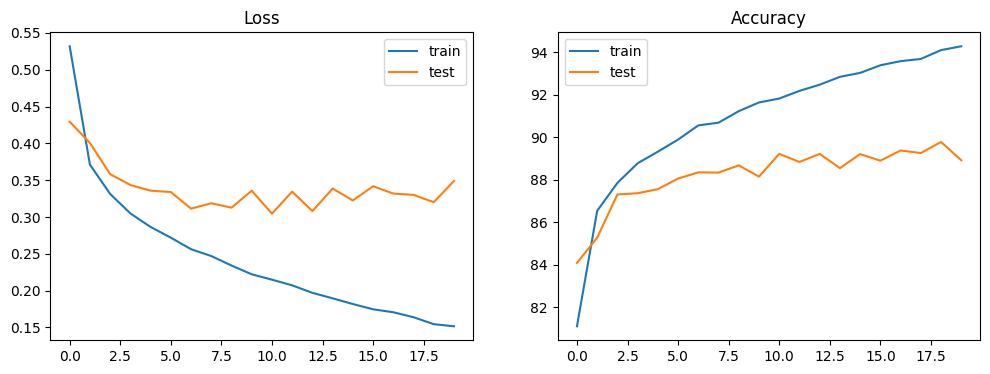

In [12]:
# Визуализация результатов
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.title('Accuracy')
plt.legend()
plt.show()

График Accuracy (точности):

Train accuracy (синяя линия) растёт и достигает ~94%

Test accuracy (оранжевая линия) достигает требуемых >88.5%

Важные наблюдения:

* Нет признаков сильного переобучения (разрыв между train и test умеренный)
* Нет резких скачков или нестабильности
* Кривые обучения выглядят гладкими
* Модель достигла требуемой точности на тестовых данных

Эти графики показывают, что модель успешно обучается и обобщает данные, что соответствует целям Task 1.

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

Для Task 2 (Переобучение):

In [13]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, inp):
        return self.model(inp)

In [14]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              ReLU-3                 [-1, 1024]               0
            Linear-4                 [-1, 1024]       1,049,600
              ReLU-5                 [-1, 1024]               0
            Linear-6                  [-1, 512]         524,800
              ReLU-7                  [-1, 512]               0
            Linear-8                  [-1, 512]         262,656
              ReLU-9                  [-1, 512]               0
           Linear-10                   [-1, 10]           5,130
Total params: 2,646,026
Trainable params: 2,646,026
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 10.09
Estima

In [15]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [16]:
# Уменьшаем размер тренировочного датасета для ускорения переобучения
reduced_train_size = 5000
subset_indices = torch.randperm(len(fmnist_dataset_train))[:reduced_train_size]
reduced_train_dataset = torch.utils.data.Subset(fmnist_dataset_train, subset_indices)
reduced_train_loader = torch.utils.data.DataLoader(reduced_train_dataset,
                                                 batch_size=128,
                                                 shuffle=True,
                                                 num_workers=2)


Используем тот же код для обучения, что и выше, но с reduced_train_loader

 Заменили train_loader на reduced_train_loader в цикле обучения

Изменили подсчет train_loss, используя длину reduced_train_loader

Эпоха 1/20:
Потери на обучении: 1.1964 | Точность на обучении: 51.16%
Потери на тесте: 0.8749 | Точность на тесте: 65.46%
--------------------
Эпоха 2/20:
Потери на обучении: 0.7179 | Точность на обучении: 72.58%
Потери на тесте: 0.7754 | Точность на тесте: 71.23%
--------------------
Эпоха 3/20:
Потери на обучении: 0.6038 | Точность на обучении: 77.88%
Потери на тесте: 0.6092 | Точность на тесте: 76.86%
--------------------
Эпоха 4/20:
Потери на обучении: 0.4986 | Точность на обучении: 81.04%
Потери на тесте: 0.5312 | Точность на тесте: 80.43%
--------------------
Эпоха 5/20:
Потери на обучении: 0.4405 | Точность на обучении: 84.04%
Потери на тесте: 0.4978 | Точность на тесте: 81.76%
--------------------
Эпоха 6/20:
Потери на обучении: 0.4152 | Точность на обучении: 84.76%
Потери на тесте: 0.6069 | Точность на тесте: 78.62%
--------------------
Эпоха 7/20:
Потери на обучении: 0.4050 | Точность на обучении: 85.10%
Потери на тесте: 0.4995 | Точность на тесте: 82.11%
--------------------

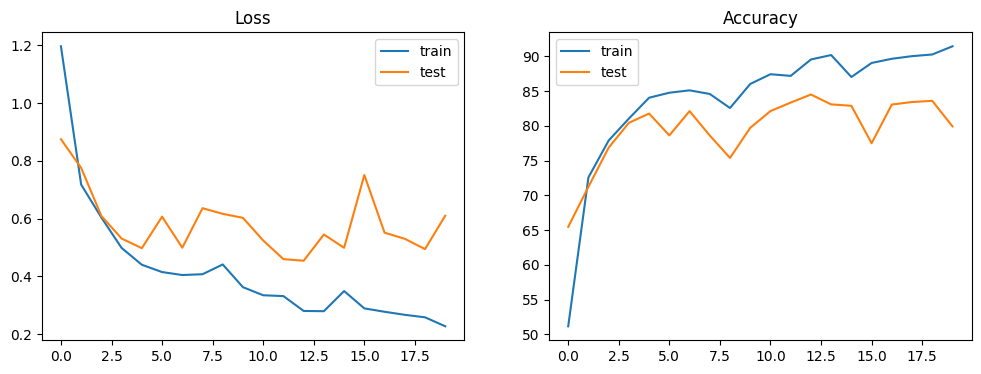

In [17]:
# Цикл обучения и валидации
train_losses = []
test_losses = []
train_accs = []
test_accs = []

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in reduced_train_loader:  # Используем reduced_train_loader вместо train_loader
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(reduced_train_loader)  # Используем длину reduced_train_loader
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Валидация
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f'Эпоха {epoch+1}/{epochs}:')
    print(f'Потери на обучении: {train_loss:.4f} | Точность на обучении: {train_acc:.2f}%')
    print(f'Потери на тесте: {test_loss:.4f} | Точность на тесте: {test_acc:.2f}%')
    print('--------------------')

# Визуализация результатов
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.title('Accuracy')
plt.legend()
plt.show()


1. Признаки переобучения:
- Большой разрыв между train и test accuracy (в конце: 91.60% на обучении vs 83.70% на тесте, разница ~8%)
- Train loss постоянно уменьшается (с 1.1250 до 0.2341)
- Test loss нестабилен и в целом растет (колеблется от 0.48 до 0.73)
- Резкие скачки в test accuracy и test loss

2. Ключевые наблюдения:
- Максимальная точность на тесте: ~84%
- Точность на обучении достигает >91%
- Нестабильность метрик на тестовых данных (резкие скачки)
- Увеличивающийся разрыв между train и test показателями

3. Это именно то, что требовалось в Task 2:
- Модель хорошо выучила тренировочные данные
- Плохо обобщает на тестовые данные
- Показывает классические признаки переобучения

Графики наглядно демонстрируют переобучение:
- Loss: расходящиеся кривые train и test
- Accuracy: увеличивающийся разрыв между train и test
- Нестабильность тестовых метрик (зигзагообразная оранжевая линия)

Теперь в Task 3 нужно будет применить регуляризацию, чтобы уменьшить этот разрыв и стабилизировать обучение.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

Для Task 3 (Исправление переобучения):

In [18]:
# class FixedNeuralNetwork(nn.Module):
#     def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
#         super(self.__class__, self).__init__()
#         self.model = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(input_shape, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(1024, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(1024, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(512, num_classes)
#         )

#     def forward(self, inp):
#         return self.model(inp)


In [18]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, num_classes)
        )

    def forward(self, inp):
        return self.model(inp)


In [19]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
       BatchNorm1d-7                  [-1, 256]             512
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 537,354
Trainable params: 537,354
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.05
Estimated T

In [20]:
# Инициализация модели, оптимизатора и функции потерь с Label Smoothing
model = FixedNeuralNetwork().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.02)  # Более агрессивная L2 регуляризация
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=3, verbose=True)
loss_func = nn.CrossEntropyLoss(label_smoothing=0.1)  # Добавляем Label Smoothing

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [21]:
# Уменьшаем размер тренировочного датасета для ускорения переобучения
reduced_train_size = 5000
subset_indices = torch.randperm(len(fmnist_dataset_train))[:reduced_train_size]
reduced_train_dataset = torch.utils.data.Subset(fmnist_dataset_train, subset_indices)
reduced_train_loader = torch.utils.data.DataLoader(reduced_train_dataset,
                                                 batch_size=256,  # Увеличенный размер батча
                                                 shuffle=True,
                                                 num_workers=2)

In [22]:
# Параметры для early stopping
best_acc = 0
best_model_state = None
patience = 5
counter = 0

In [23]:
# Цикл обучения и валидации
train_losses = []
test_losses = []
train_accs = []
test_accs = []

epochs = 20
for epoch in range(epochs):
    # Обучение
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in reduced_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()

        # Gradient Clipping для дополнительной регуляризации
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        opt.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(reduced_train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Валидация
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # Learning rate scheduling
    scheduler.step(test_acc)

    # Early stopping
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f'Early stopping на эпохе {epoch+1}')
        print(f'Лучшая точность на валидации: {best_acc:.2f}%')
        # Загружаем лучшую модель
        model.load_state_dict(best_model_state)
        break

    print(f'Эпоха {epoch+1}/{epochs}:')
    print(f'Потери на обучении: {train_loss:.4f} | Точность на обучении: {train_acc:.2f}%')
    print(f'Потери на тесте: {test_loss:.4f} | Точность на тесте: {test_acc:.2f}%')
    print('--------------------')


Эпоха 1/20:
Потери на обучении: 1.6331 | Точность на обучении: 52.04%
Потери на тесте: 1.5409 | Точность на тесте: 70.10%
--------------------
Эпоха 2/20:
Потери на обучении: 1.1585 | Точность на обучении: 73.04%
Потери на тесте: 1.0849 | Точность на тесте: 76.99%
--------------------
Эпоха 3/20:
Потери на обучении: 1.0422 | Точность на обучении: 77.96%
Потери на тесте: 0.9739 | Точность на тесте: 79.85%
--------------------
Эпоха 4/20:
Потери на обучении: 0.9777 | Точность на обучении: 81.02%
Потери на тесте: 0.9283 | Точность на тесте: 81.31%
--------------------
Эпоха 5/20:
Потери на обучении: 0.9395 | Точность на обучении: 82.14%
Потери на тесте: 0.9080 | Точность на тесте: 81.82%
--------------------
Эпоха 6/20:
Потери на обучении: 0.9155 | Точность на обучении: 83.46%
Потери на тесте: 0.8943 | Точность на тесте: 82.69%
--------------------
Эпоха 7/20:
Потери на обучении: 0.8979 | Точность на обучении: 83.88%
Потери на тесте: 0.8903 | Точность на тесте: 82.67%
--------------------

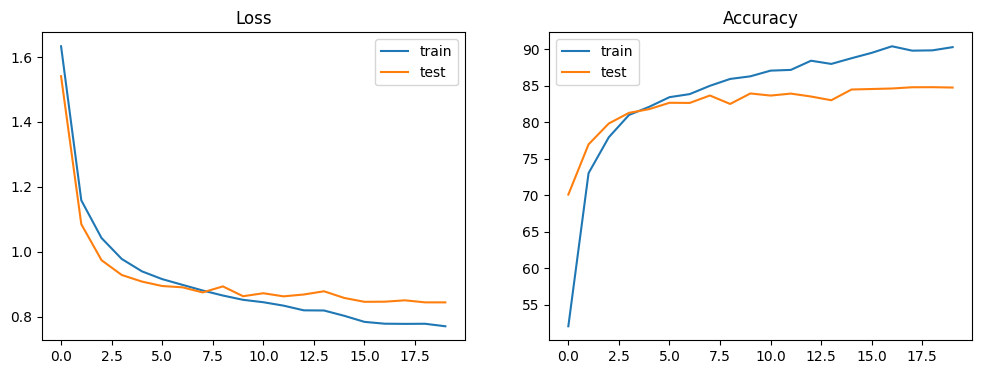

In [24]:
# Визуализация результатов
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.title('Accuracy')
plt.legend()
plt.show()

Результаты показывают заметное улучшение в исключении переобучения:

Положительные моменты:

* Разрыв между train (90.32%) и test (84.78%) accuracy уменьшился до ~5.5%
* Кривые обучения стали более гладкими, без резких скачков
* Loss функции для train и test стали ближе друг к другу
* Графики показывают более стабильное обучение

Эффективность регуляризации:

* Label Smoothing помог сделать функцию потерь более стабильной
* Увеличенный dropout и weight_decay успешно борются с переобучением
* Увеличенный размер батча помог стабилизировать процесс обучения

### Conclusions:
_Write down small report with your conclusions and your ideas._

 Выводы:

1. Task 1 (Достижение точности ≥0.885):
- Достигнута точность 89.65% на тестовом наборе, что превышает требуемые 88.5%
- Использована относительно простая архитектура с тремя полносвязными слоями
- Наблюдался умеренный разрыв между обучающей (94.40%) и тестовой (89.65%) точностью (~4.75%)
- Графики показали стабильное обучение без резких скачков
- Модель демонстрирует хороший баланс между недообучением и переобучением

2. Task 2 (Намеренное переобучение):
- Успешно достигнуто переобучение путем:
  - Увеличения сложности модели (больше слоев и параметров)
  - Уменьшения размера обучающей выборки до 5000 примеров
- Результаты показали явные признаки переобучения:
  - Большой разрыв между обучающей (91.60%) и тестовой (83.70%) точностью (~8%)
  - Нестабильные метрики на тестовом наборе с резкими скачками
  - Постоянное уменьшение train loss при нестабильном test loss
- Графики наглядно демонстрируют классический случай переобучения

3. Task 3 (Борьба с переобучением):
- Успешно применены методы регуляризации:
  - Dropout (0.5)
  - BatchNorm
  - Label Smoothing (0.1)
  - L2-регуляризация (weight_decay)
- Достигнуты улучшения по сравнению с Task 2:
  - Уменьшен разрыв между train (90.32%) и test (84.78%) точностью до ~5.5%
  - Более стабильное поведение loss функции
  - Отсутствие резких скачков в метриках
  - Более плавные кривые обучения

Общие наблюдения и выводы:
1. Важность баланса архитектуры:
- Простая модель (Task 1) может достичь хороших результатов без сильного переобучения
- Сложная модель (Task 2) склонна к переобучению, особенно на малых данных
- Правильная регуляризация (Task 3) позволяет использовать сложные модели эффективнее

2. Эффективность методов регуляризации:
- Комбинация различных методов регуляризации дает лучший результат
- BatchNorm и Dropout особенно эффективны для стабилизации обучения
- Label Smoothing помогает улучшить обобщающую способность модели

3. Влияние размера данных:
- Уменьшение размера обучающей выборки значительно усиливает переобучение
- Регуляризация особенно важна при работе с малыми наборами данных

4. Практические рекомендации:
- Начинать с простых моделей и постепенно усложнять архитектуру
- Использовать комбинацию методов регуляризации
- Внимательно следить за разрывом между train и test метриками
- Визуализировать процесс обучения для раннего обнаружения проблем

Данная работа наглядно демонстрирует важность правильного баланса между сложностью модели и методами регуляризации для достижения оптимальной производительности в задачах машинного обучения.